Example notebook to demonstrate how to make diagnostic plots using built in methods  

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt

from gw_eccentricity import get_available_methods
from gw_eccentricity import measure_eccentricity
from gw_eccentricity.load_data import load_waveform
from gw_eccentricity.compare_methods import compute_errors_between_methods

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [2]:
import glob
import matplotlib.pyplot as plt
from gw_eccentricity.plot_settings import use_fancy_plotsettings, figWidthsOneColDict, colorsDict
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
available_param_sets = {
    "1": [1, 0, 0],
    "2": [2, 0.5, 0.5],
    "3": [4, -0.6, -0.6],
    "4": [6, 0.4, -0.4]}

In [4]:
param_set = "3"
num_orbits_to_exclude_before_merger = 5

In [5]:
q, chi1, chi2 = available_param_sets[param_set]
eob_waveforms = sorted(glob.glob(f"../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q{q:.2f}_chi1z{chi1:.2f}_chi2z{chi2:.2f}_*_Momega00.010_meanAno1.571.h5"))

In [6]:
def compute_errors(method1, method2, waveform_path, zeroecc_waveform_path):
    extra_kwargs = {"debug": False,
                    "num_orbits_to_exclude_before_merger": num_orbits_to_exclude_before_merger}
    waveform_keywords = {
        "filepath": waveform_path,
        "filepath_zero_ecc": zeroecc_waveform_path,
        "include_zero_ecc": True}
    dataDict = load_waveform(catalog="EOB", **waveform_keywords)
    tref_vec = dataDict["t"]
    tref_out1, ecc_vec1, mean_ano_vec1, gwecc_obj1 = measure_eccentricity(
        tref_in=tref_vec,
        dataDict=dataDict,
        method=method1, 
        return_gwecc_object=True,
        extra_kwargs=extra_kwargs)
    tref_out2, ecc_vec2, mean_ano_vec2, gwecc_obj2 = measure_eccentricity(
        tref_in=tref_vec,
        dataDict=dataDict,
        method=method2, 
        return_gwecc_object=True,
        extra_kwargs=extra_kwargs)
    t, ecc_errors, mean_ano_errors = compute_errors_between_methods(gwecc_obj1, gwecc_obj2)[:3]
    
    return t, ecc_errors, mean_ano_errors, gwecc_obj1, gwecc_obj2

In [7]:
zeroecc_path = f"../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q{q:.2f}_chi1z{chi1:.2f}_chi2z{chi2:.2f}_EOBecc0.0000000000_Momega00.002_meanAno1.571.h5"
t, ecc_errs, mean_ano_errs, gwecc_obj1, gwecc_obj2 = compute_errors("ResidualAmplitude", "FrequencyFits", eob_waveforms[140], zeroecc_path)

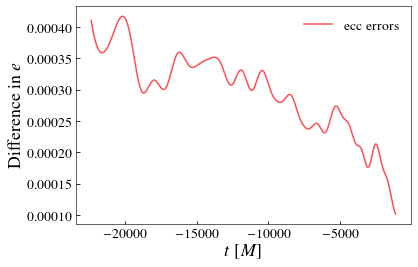

In [9]:
style = "Notebook"
use_fancy_plotsettings(style=style)
fig, ax = plt.subplots(figsize=(figWidthsOneColDict[journal], 4))
ax.plot(t, ecc_errs, label="ecc errors")
ax.set_xlabel(r"$t$ [$M$]")
ax.set_ylabel(r"Difference in $e$")
ax.legend()

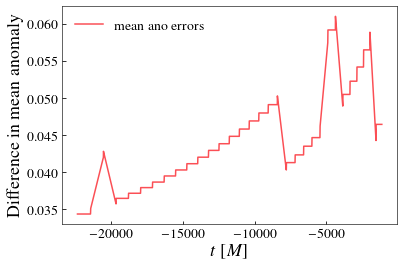

In [10]:
style = "Notebook"
use_fancy_plotsettings(style=style)
fig, ax = plt.subplots(figsize=(figWidthsOneColDict[journal], 4))
ax.plot(t, mean_ano_errs, label="mean ano errors")
ax.set_xlabel(r"$t$ [$M$]")
ax.set_ylabel(r"Difference in mean anomaly")
ax.legend()

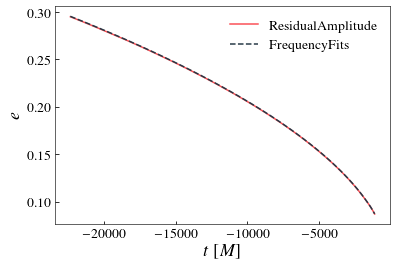

In [11]:
style = "Notebook"
use_fancy_plotsettings(style=style)
fig, ax = plt.subplots(figsize=(figWidthsOneColDict[journal], 4))
ax.plot(gwecc_obj1.tref_out, gwecc_obj1.ecc_ref, label=gwecc_obj1.method)
ax.plot(gwecc_obj2.tref_out, gwecc_obj2.ecc_ref, label=gwecc_obj2.method, ls="--")
ax.set_xlabel(r"$t$ [$M$]")
ax.set_ylabel(r"$e$")
ax.legend()

### Loop over all eob waveforms in set 1 and compute the max error in eccentricity

In [12]:
import re
from tqdm import tqdm
import numpy as np

In [13]:
ecc_max_errs = []
t_max_errs = []
eccs = []
failed_cases = []
failed_eccs = []
tmaxes = []
tmins = []
zeroecc_path_set1 = "../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.0000000000_Momega00.002_meanAno1.571.h5"
for waveform in tqdm(eob_waveforms):
    # get the ecc from waveform path string
    ecc = re.search("\d.\d{10}", waveform)[0]
    try:
        t, ecc_errs, mean_ano_errs, gwecc_obj1, gwecc_obj2 = compute_errors("ResidualAmplitude", "FrequencyFits", waveform, zeroecc_path)
        eccs.append(float(ecc))
        ecc_max_errs.append(max(np.abs(ecc_errs)))
        t_max_errs.append(t[np.abs(ecc_errs).argmax()])
        tmins.append([gwecc_obj1.t_min, gwecc_obj2.t_min])
        tmaxes.append([gwecc_obj1.t_max, gwecc_obj2.t_max])
    except Exception:
        failed_eccs.append(ecc)
        failed_cases.append(waveform)
ecc_max_errs = np.array(ecc_max_errs)
t_max_errs = np.array(t_max_errs)
eccs = np.array(eccs)
failed_cases = np.array(failed_cases)
failed_eccs = np.array(failed_eccs)
tmaxes = np.array(tmaxes)
tmins = np.array(tmins)

  0%|                                                                                                                                                                                      | 0/150 [00:00<?, ?it/s]/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:465: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:662: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase d

In [37]:
failed_eccs

array([], dtype=float64)

### Make scatter plot of absolute errors

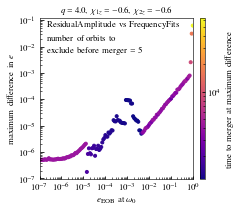

In [37]:
cmap = cm.get_cmap("plasma")
style = "APS"
use_fancy_plotsettings(style=style)
fig, ax = plt.subplots(figsize=(figWidthsOneColDict[style], 3))
scatter = ax.scatter(eccs, ecc_max_errs, c=-np.array(t_max_errs),
                     cmap=cmap,
                     # s=15,
                     marker=".")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$e_\mathrm{EOB}$ at $\omega_0$")
ax.set_ylabel("maximum difference in $e$")
ax.set_title(fr"$q={q:.1f}$, $\chi_{{1z}}={chi1:.1f}$, $\chi_{{2z}}={chi2:.1f}$", ha="center")

# set major ticks
locmaj = mpl.ticker.LogLocator(base=10, numticks=20)
ax.xaxis.set_major_locator(locmaj)
# set minor ticks
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(0.1, 1.0, 0.1),
                               numticks=20)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xlim(1e-7, 1.0)

# add colorbar
norm = mpl.colors.LogNorm(-np.array(t_max_errs).max(), -np.array(t_max_errs).min())
# levels = np.append(np.array([-t_max_errs.max()]), np.arange(2e3, 15e3, 2e3))
# levels = np.append(levels, np.array([-t_max_errs.min()]))
# levels = np.linspace(1e3, 6.5e4, 5)
# norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"time to merger at maximum difference")

# indicate methods
ax.text(0.05, 0.99, f"{gwecc_obj1.method} vs {gwecc_obj2.method}", ha="left", va="top",
       transform=ax.transAxes)
ax.text(0.05, 0.9, fr"\noindent number of orbits to \\exclude before merger = {num_orbits_to_exclude_before_merger}", ha="left", va="top",
       transform=ax.transAxes)
fig.tight_layout()
fig.savefig(f"max_ecc_erros_{gwecc_obj1.method}_{gwecc_obj2.method}_paramset_{param_set}_num_orbits_{num_orbits_to_exclude_before_merger}.pdf")

### plot the tmin and tmax

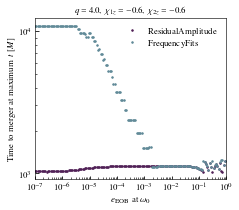

In [40]:
use_fancy_plotsettings(journal=journal)
fig, ax = plt.subplots(figsize=(figWidthsOneColDict[journal], 3))
# ax.plot(eccs, -tmins[:, 0], c=colorsDict[gwecc_obj1.method], marker=".", markersize=3, ls="", label=rf"$t_\mathrm{{min}}$ {gwecc_obj1.method}")
# ax.plot(eccs, -tmins[:, 1], c=colorsDict[gwecc_obj2.method], marker=".", markersize=3, ls="", label=rf"$t_\mathrm{{min}}$ {gwecc_obj2.method}")

ax.plot(eccs, -tmaxes[:, 0], c=colorsDict[gwecc_obj1.method], marker=".", markersize=3, ls="", label=rf"{gwecc_obj1.method}")
ax.plot(eccs, -tmaxes[:, 1], c=colorsDict[gwecc_obj2.method], marker=".", markersize=3, ls="", label=rf"{gwecc_obj2.method}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$e_\mathrm{EOB}$ at $\omega_0$")
ax.set_ylabel("Time to merger at maximum $t$ [$M$]")
ax.set_title(fr"$q={q:.1f}$, $\chi_{{1z}}={chi1:.1f}$, $\chi_{{2z}}={chi2:.1f}$", ha="center")

# set major ticks
locmaj = mpl.ticker.LogLocator(base=10, numticks=20)
ax.xaxis.set_major_locator(locmaj)
# set minor ticks
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(0.1, 1.0, 0.1),
                               numticks=20)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xlim(1e-7, 1.0)

ax.legend()
fig.tight_layout()
fig.savefig(f"tmax_{gwecc_obj1.method}_{gwecc_obj2.method}_paramset_{param_set}_num_orbits_{num_orbits_to_exclude_before_merger}.png")